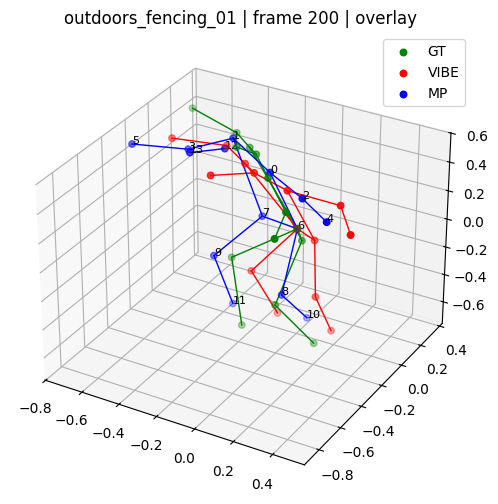

In [ ]:
# === Visualización JSON 3-modos (overlay / articulación / MP4) ===
import json, math, os, shutil, os.path as osp
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FFMpegWriter

# ---------- CONFIGURACIÓN ----------
# Ruta al JSON unificado (GT + VIBE + MediaPipe) generado en GenerarJSON.ipynb
JSON_PATH = "/content/dataset_3models.json"   # ajusta la ruta si es necesario

# Parámetros principales de visualización:
# - Modo: 1=overlay 3D, 2=una articulación, 3=exportar MP4
# - MostrarGT / MostrarVIBE / MostrarMP: activar o desactivar cada modelo
Modo = 1                 # 1: overlay  |  2: una articulación  |  3: exportar MP4
MostrarGT = 1            # 0/1
MostrarVIBE = 1          # 0/1
MostrarMP = 1            # 0/1

CENTER_VISUAL = 1     # 0=sin centrar, 1=centrar para graficar
CENTER_JOINT  = 6     # índice para centrar (tu pedido: 6)

secuencia = "outdoors_fencing_01"   # nombre EXACTO del video_id en el JSON
frame_idx = 200                      # usado en Modo 1 y 2
joint_name = "Muñeca_D"              # usado en Modo 2

ANGLE_DEG = 0          # rotación en X SOLO para visualizar (0, 90 o -90)
show_labels = True     # etiquetas 0..13 (en overlay y opcionalmente en MP4)
PID = 1                # id de persona (tu JSON usa 1)

# Parámetros para Modo 3 (MP4)
fps = 25
out_path = None         # None -> "{video_id}_overlay.mp4"
max_frames = None       # None = todos; o p.ej. 300 para prueba
bitrate = 1800
dpi = 120

# ---------- Helpers JSON / datos ----------
# Leer el JSON, elegir una secuencia por video_id y extraer k3d (3xK) de un modelo
def load_data(json_path=JSON_PATH):
    with open(json_path, "r", encoding="utf-8") as f:
        return json.load(f)

def get_seq(data, video_id):
    for s in data["sequences"]:
        if s["video_id"] == video_id:
            return s
    raise KeyError(f"video_id no encontrado: {video_id}")

def get_k3d(seq, frame_idx, model, pid=PID, angle_deg=ANGLE_DEG):
    """Devuelve (K,3) float; None->nan; aplica rotación X y centrado visual opcionales."""
    fr = seq["frames"][frame_idx]
    person = next(p for p in fr["persons"] if p["id"] == pid)
    k3d = np.array(person["models"][model]["k3d"], dtype=object)  # (3,K)

    # 3xK -> (K,3)
    X = np.array([np.nan if v is None else float(v) for v in k3d[0]], dtype=np.float32)
    Y = np.array([np.nan if v is None else float(v) for v in k3d[1]], dtype=np.float32)
    Z = np.array([np.nan if v is None else float(v) for v in k3d[2]], dtype=np.float32)
    pts = np.stack([X, Y, Z], axis=1)  # (K,3)

    # Rotación en X (solo visual)
    if angle_deg:
        th = math.radians(angle_deg); c, s = math.cos(th), math.sin(th)
        x, y, z = pts[:,0], pts[:,1], pts[:,2]
        pts = np.stack([x, y*c - z*s, y*s + z*c], axis=1)

    # Centrado visual en la articulación elegida (p.ej., 6 = Cadera_I)
    if CENTER_VISUAL:
        if 0 <= CENTER_JOINT < pts.shape[0] and np.isfinite(pts[CENTER_JOINT]).all():
            pts = pts - pts[CENTER_JOINT]

    return pts

def get_conns(data, model):
    if model in ("gt","vibe"):
        return [tuple(x) for x in data["connections"]["gt_vibe"]]
    elif model == "mp":
        return [tuple(x) for x in data["connections"]["mediapipe"]]
    else:
        raise ValueError(f"Modelo desconocido: {model}")

def _set_equal_axes(ax, P):
    import numpy as np
    P = np.asarray(P, dtype=np.float32)
    if P.ndim != 2 or P.shape[1] != 3:
        ax.set_xlim(-1,1); ax.set_ylim(-1,1); ax.set_zlim(-1,1); return
    # usar solo puntos finitos
    finite_rows = np.isfinite(P).all(axis=1)
    if not finite_rows.any():
        ax.set_xlim(-1,1); ax.set_ylim(-1,1); ax.set_zlim(-1,1); return
    P = P[finite_rows]

    mins = np.nanmin(P, axis=0)
    maxs = np.nanmax(P, axis=0)
    ctr = (mins + maxs) / 2.0
    r = float(np.nanmax((maxs - mins) / 2.0))  # ESCALAR
    if not np.isfinite(r) or r <= 0: r = 1.0

    ax.set_xlim(ctr[0]-r, ctr[0]+r)
    ax.set_ylim(ctr[1]-r, ctr[1]+r)
    ax.set_zlim(ctr[2]-r, ctr[2]+r)


# ---------- Selección de modelos según flags ----------
MODEL_COLORS = {"gt":"g", "vibe":"r", "mp":"b"}  # green/red/blue
models = []
if MostrarGT:    models.append("gt")
if MostrarVIBE:  models.append("vibe")
if MostrarMP:    models.append("mp")
if not models:
    raise ValueError("No seleccionaste ningún modelo (activa MostrarGT/MostrarVIBE/MostrarMP).")

# ---------- Cargar JSON ----------
data = load_data(JSON_PATH)
seq = get_seq(data, secuencia)
K = len(data["keypoint_names"])

# ===================== MODO 1: Overlay en un frame =====================
# Dibuja simultáneamente GT, VIBE y MediaPipe en 3D para un único frame.
if Modo == 1:
    fig = plt.figure(figsize=(6,6))
    ax = fig.add_subplot(111, projection='3d')
    ax.set_title(f"{secuencia} | frame {frame_idx} | overlay")

    all_pts = []
    for m in models:
        pts = get_k3d(seq, frame_idx, m)
        conns = get_conns(data, m)
        col = MODEL_COLORS.get(m, 'k')
        ax.scatter(pts[:,0], pts[:,1], pts[:,2], label=m.upper(), s=22, c=col)
        for a,b in conns:
            if 0 <= a < K and 0 <= b < K and np.all(np.isfinite(pts[[a,b]])):
                ax.plot([pts[a,0], pts[b,0]],
                        [pts[a,1], pts[b,1]],
                        [pts[a,2], pts[b,2]], c=col, linewidth=1)
        all_pts.append(pts)

    if show_labels:
        pts_lab = all_pts[-1]
        for i,(X,Y,Z) in enumerate(pts_lab):
            if np.isfinite([X,Y,Z]).all():
                ax.text(X, Y, Z, str(i), fontsize=8)

    _set_equal_axes(ax, np.vstack(all_pts))
    ax.legend()
    plt.show()

# ===================== MODO 2: Una articulación en un frame =====================
# Muestra en 3D la misma articulación (ej. Muñeca_D) para cada modelo en ese frame.
elif Modo == 2:
    kp = data["keypoint_names"]
    if joint_name not in kp:
        raise KeyError(f"Articulación no existe en keypoint_names: {joint_name}")
    j = kp.index(joint_name)

    fig = plt.figure(figsize=(6,6))
    ax = fig.add_subplot(111, projection='3d')
    ax.set_title(f"{secuencia} | frame {frame_idx} | joint: {joint_name}")

    P = []
    for m in models:
        pts = get_k3d(seq, frame_idx, m)
        col = MODEL_COLORS.get(m, 'k')
        X, Y, Z = pts[j]
        ax.scatter([X],[Y],[Z], s=70, c=col, label=f"{m.upper()} ({X:.3f},{Y:.3f},{Z:.3f})")
        P.append(pts[j:j+1])

    _set_equal_axes(ax, np.vstack(P))
    ax.legend()
    plt.show()

# ===================== MODO 3: Exportar MP4 (overlay de modelos) =====================
# Genera un video MP4 con el overlay de los modelos a lo largo de todos los frames.
elif Modo == 3:
    if shutil.which("ffmpeg") is None:
        raise EnvironmentError("ffmpeg no está instalado. En Colab:\n!apt-get update -qq && apt-get install -y ffmpeg")

    T = len(seq["frames"])
    if max_frames is not None:
        T = min(T, int(max_frames))

    # Precalcular puntos (T,K,3) por modelo
    stacks = []
    for m in models:
        pts_list = [get_k3d(seq, f, m) for f in range(T)]
        stacks.append(np.stack(pts_list, axis=0))
    S = np.concatenate(stacks, axis=1)  # (T, K*#models, 3) para escalar
    finite = np.isfinite(S)
    if not finite.any():
        raise ValueError("Todos los valores son NaN/Inf.")

    mins = np.nanmin(S, axis=(0,1)); maxs = np.nanmax(S, axis=(0,1))
    ctr = (mins + maxs)/2; rad = (maxs - mins)/2
    rad[rad <= 0] = 1.0

    if out_path is None:
        out_path = f"{secuencia}_overlay.mp4"

    fig = plt.figure(figsize=(6,6))
    ax = fig.add_subplot(111, projection='3d')
    ax.set_title(f"{secuencia} | overlay")
    ax.set_xlim(ctr[0]-rad[0], ctr[0]+rad[0])
    ax.set_ylim(ctr[1]-rad[1], ctr[1]+rad[1])
    ax.set_zlim(ctr[2]-rad[2], ctr[2]+rad[2])

    # Inicializar con frame 0
    lines_by_model = {}
    texts = []
    for m, stack in zip(models, stacks):
        pts0 = stack[0]  # (K,3)
        conns = get_conns(data, m)
        col = MODEL_COLORS.get(m, 'k')
        ax.scatter(pts0[:,0], pts0[:,1], pts0[:,2], c=col, s=18, label=m.upper())
        model_lines = []
        for a,b in conns:
            line, = ax.plot([pts0[a,0], pts0[b,0]],
                            [pts0[a,1], pts0[b,1]],
                            [pts0[a,2], pts0[b,2]], c=col, linewidth=1)
            model_lines.append((a,b,line))
        lines_by_model[m] = model_lines

    if show_labels:
        for i,(X,Y,Z) in enumerate(stacks[0][0]):  # etiquetas según el primer modelo
            if np.isfinite([X,Y,Z]).all():
                texts.append(ax.text(X,Y,Z,str(i), fontsize=8))

    ax.legend()

    def update_frame(t):
        for m, stack in zip(models, stacks):
            pts = stack[t]
            for (a,b,line) in lines_by_model[m]:
                if 0 <= a < K and 0 <= b < K and np.all(np.isfinite(pts[[a,b]])):
                    line.set_data([pts[a,0], pts[b,0]], [pts[a,1], pts[b,1]])
                    line.set_3d_properties([pts[a,2], pts[b,2]])
        if show_labels and texts:
            pts0 = stacks[0][t]
            for i,txt in enumerate(texts):
                X,Y,Z = pts0[i]
                if np.isfinite([X,Y,Z]).all():
                    txt.set_position((X,Y))
                    txt.set_3d_properties(Z, zdir='z')

    writer = FFMpegWriter(fps=fps, bitrate=bitrate)
    with writer.saving(fig, out_path, dpi=dpi):
        for t in range(T):
            update_frame(t)
            writer.grab_frame()
    plt.close(fig)
    print(f"MP4 listo: {out_path}  (frames: {T}, fps: {fps})")

else:
    raise ValueError("Modo inválido. Usa 1, 2 o 3.")


In [ ]:
# === Overlay 3D interactivo (GT + VIBE + MP) en el mismo frame ===
# Visualización alternativa con Plotly: muestra GT, VIBE y MediaPipe en 3D en un frame concreto
# usando el JSON corregido (dataset_3models_fix.json).
import json, math, numpy as np
import plotly.graph_objects as go

# -------- CONFIG --------
# JSON ya corregido (swap de caderas en MediaPipe) generado en GenerarJSON.ipynb
JSON_PATH   = "/content/dataset_3models_fix.json"
VIDEO_ID    = "outdoors_fencing_01"
FRAME_IDX   = 600
MODELS      = ("gt","vibe","mp")   # elige subset: ("gt","mp"), ("vibe",), etc.
ANGLE_DEG   = 0                    # rotación X solo para visualizar (0/90/-90)
CENTER_VISUAL = 1                  # 1=centrar, 0=no
CENTER_JOINT  = 6                  # cadera izq.
SHOW_LABELS_ON = "mp"              # modelo sobre el que poner índices 0..13 (o None)

COLORS = {"gt":"green","vibe":"red","mp":"blue"}

# -------- Helpers --------
def load_json(path):
    with open(path, "r", encoding="utf-8") as f:
        return json.load(f)

def get_seq(data, vid):
    for s in data["sequences"]:
        if s["video_id"] == vid:
            return s
    raise KeyError(f"video_id no encontrado: {vid}")

def get_conns(data, model):
    return (data["connections"]["gt_vibe"] if model in ("gt","vibe")
            else data["connections"]["mediapipe"])

def get_k3d(seq, f, model, pid=1, angle_deg=0, center=False, center_joint=6):
    fr = seq["frames"][f]
    person = next(p for p in fr["persons"] if p["id"] == pid)
    k3d = person["models"][model]["k3d"]  # 3xK
    X = np.array([np.nan if v is None else float(v) for v in k3d[0]], dtype=np.float32)
    Y = np.array([np.nan if v is None else float(v) for v in k3d[1]], dtype=np.float32)
    Z = np.array([np.nan if v is None else float(v) for v in k3d[2]], dtype=np.float32)
    pts = np.stack([X, Y, Z], axis=1)  # (K,3)
    if angle_deg:
        th = math.radians(angle_deg); c, s = math.cos(th), math.sin(th)
        x, y, z = pts[:,0], pts[:,1], pts[:,2]
        pts = np.stack([x, y*c - z*s, y*s + z*c], axis=1)
    if center and 0 <= center_joint < pts.shape[0] and np.isfinite(pts[center_joint]).all():
        pts = pts - pts[center_joint]
    return pts

# -------- Cargar y preparar --------
data = load_json(JSON_PATH)
seq  = get_seq(data, VIDEO_ID)
K    = len(data["keypoint_names"])

fig = go.Figure()
stack_all = []

# Para cada modelo seleccionado: obtener puntos 3D, crear marcadores y líneas de esqueleto en Plotly
for m in MODELS:
    pts = get_k3d(seq, FRAME_IDX, m, angle_deg=ANGLE_DEG,
                  center=bool(CENTER_VISUAL), center_joint=CENTER_JOINT)
    stack_all.append(pts)
    conns = get_conns(data, m)
    col = COLORS.get(m, "gray")

    # puntos
    fig.add_trace(go.Scatter3d(
        x=pts[:,0], y=pts[:,1], z=pts[:,2],
        mode="markers" if m != SHOW_LABELS_ON else "markers+text",
        marker=dict(size=5, color=col),
        text=[str(i) for i in range(K)] if m == SHOW_LABELS_ON else None,
        textposition="top center",
        name=m.upper()
    ))

    # conexiones
    seg_x, seg_y, seg_z = [], [], []
    for a,b in conns:
        if 0<=a<K and 0<=b<K and np.all(np.isfinite(pts[[a,b]])):
            seg_x += [pts[a,0], pts[b,0], None]
            seg_y += [pts[a,1], pts[b,1], None]
            seg_z += [pts[a,2], pts[b,2], None]
    fig.add_trace(go.Scatter3d(
        x=seg_x, y=seg_y, z=seg_z, mode="lines",
        line=dict(width=3, color=col), name=f"{m.upper()} bones", showlegend=False
    ))

# ejes iguales: mismo rango en X,Y,Z para que las poses no se vean estiradas
P = np.vstack([p[np.isfinite(p).all(axis=1)] for p in stack_all if p.size])
mins = np.nanmin(P, axis=0); maxs = np.nanmax(P, axis=0)
ctr  = (mins + maxs)/2.0; rad = float(np.nanmax((maxs - mins)/2.0)) or 1.0

fig.update_layout(
    title=f"{VIDEO_ID} | frame {FRAME_IDX} | rotX {ANGLE_DEG}° | center({CENTER_VISUAL})@{CENTER_JOINT}",
    scene=dict(
        xaxis=dict(range=[ctr[0]-rad, ctr[0]+rad], title="X"),
        yaxis=dict(range=[ctr[1]-rad, ctr[1]+rad], title="Y"),
        zaxis=dict(range=[ctr[2]-rad, ctr[2]+rad], title="Z"),
        aspectmode="cube",
    ),
    width=800, height=700,
    showlegend=True
)

fig.show()



In [ ]:
# === MPJPE por articulación (GT vs VIBE / MP) → CSV por secuencia ===
# Calcula MPJPE 3D por articulación (GT vs VIBE y GT vs MediaPipe) para CADA secuencia del JSON
# y guarda un CSV por secuencia en OUT_DIR.
import json, os, numpy as np, pandas as pd

JSON_PATH = "/content/dataset_3models_fix.json"  # JSON unificado y corregido (GT + VIBE + MP)
OUT_DIR = "/content/mpjpe_csv"                   # carpeta donde se guardan los CSV por secuencia
DO_CENTERED = True       # True: además guarda CSVs centrados en la articulación 6
CENTER_JOINT = 6

os.makedirs(OUT_DIR, exist_ok=True)

def to_K3(k3d_3xK):
    X = np.array([np.nan if v is None else float(v) for v in k3d_3xK[0]], dtype=np.float32)
    Y = np.array([np.nan if v is None else float(v) for v in k3d_3xK[1]], dtype=np.float32)
    Z = np.array([np.nan if v is None else float(v) for v in k3d_3xK[2]], dtype=np.float32)
    return np.stack([X, Y, Z], axis=1)  # (K,3)

def seq_to_TK3(seq, model_key, pid=1):
    T = len(seq["frames"])
    sample = seq["frames"][0]["persons"][0]["models"][model_key]["k3d"]
    K = len(sample[0])
    arr = np.full((T, K, 3), np.nan, dtype=np.float32)
    for t, fr in enumerate(seq["frames"]):
        person = next(p for p in fr["persons"] if p["id"] == pid)
        arr[t] = to_K3(person["models"][model_key]["k3d"])
    return arr  # (T,K,3)

# MPJPE por articulación:
# devuelve un vector (K,) con el error medio en mm de cada articulación,
# considerando solo los frames donde ambos modelos tienen datos finitos.
def mpjpe_per_joint(P, G, center_joint=None):
    P = P.copy(); G = G.copy()
    if center_joint is not None:
        pj = P[:, center_joint, :]  # (T,3)
        gj = G[:, center_joint, :]
        m = np.isfinite(pj).all(axis=1) & np.isfinite(gj).all(axis=1)
        P[m] = P[m] - pj[m][:, None, :]
        G[m] = G[m] - gj[m][:, None, :]
    D = np.linalg.norm(P - G, axis=2)  # (T,K)
    return np.nanmean(D, axis=0)       # (K,)

with open(JSON_PATH, "r", encoding="utf-8") as f:
    data = json.load(f)

kp_names = data["keypoint_names"]
seqs = data["sequences"]

for seq in seqs:
    vid = seq["video_id"]
    GT = seq_to_TK3(seq, "gt")
    MP = seq_to_TK3(seq, "mp")
    VB = seq_to_TK3(seq, "vibe")

    T = min(GT.shape[0], MP.shape[0], VB.shape[0])
    GT, MP, VB = GT[:T], MP[:T], VB[:T]

    # --- Escenario: sin centrar ---
    # MPJPE con coordenadas tal como vienen en el JSON (sin centrar en la cadera)
    mp_err = mpjpe_per_joint(MP, GT, center_joint=None)
    vb_err = mpjpe_per_joint(VB, GT, center_joint=None)
    df = pd.DataFrame({
        "MPJPE VIBE": vb_err.astype(np.float32),
        "MPJPE MP":   mp_err.astype(np.float32),
    }, index=kp_names)
    out_csv = os.path.join(OUT_DIR, f"{vid}__original.csv")
    df.to_csv(out_csv)
    print(f"OK: {out_csv}")

    # --- Escenario: centrado en joint 6 (opcional) ---
    # MPJPE después de recentrar ambas poses en la articulación 6 (cadera),
    # para comparar solo la forma de la pose y no la posición global.
    if DO_CENTERED:
        mp_err_c = mpjpe_per_joint(MP, GT, center_joint=CENTER_JOINT)
        vb_err_c = mpjpe_per_joint(VB, GT, center_joint=CENTER_JOINT)
        df_c = pd.DataFrame({
            "MPJPE VIBE": vb_err_c.astype(np.float32),
            "MPJPE MP":   mp_err_c.astype(np.float32),
        }, index=kp_names)
        out_csv_c = os.path.join(OUT_DIR, f"{vid}__centered_hip.csv")
        df_c.to_csv(out_csv_c)
        print(f"OK: {out_csv_c}")

# Al finalizar, OUT_DIR contiene un CSV por secuencia (y su versión centrada si DO_CENTERED=True).
print("Listo. CSVs en:", OUT_DIR)



OK: /content/mpjpe_csv/courtyard_backpack_00__original.csv
OK: /content/mpjpe_csv/courtyard_backpack_00__centered_hip.csv
OK: /content/mpjpe_csv/courtyard_bodyScannerMotions_00__original.csv
OK: /content/mpjpe_csv/courtyard_bodyScannerMotions_00__centered_hip.csv
OK: /content/mpjpe_csv/courtyard_box_00__original.csv
OK: /content/mpjpe_csv/courtyard_box_00__centered_hip.csv
OK: /content/mpjpe_csv/courtyard_jumpBench_01__original.csv
OK: /content/mpjpe_csv/courtyard_jumpBench_01__centered_hip.csv
OK: /content/mpjpe_csv/courtyard_laceShoe_00__original.csv
OK: /content/mpjpe_csv/courtyard_laceShoe_00__centered_hip.csv
OK: /content/mpjpe_csv/courtyard_relaxOnBench_00__original.csv
OK: /content/mpjpe_csv/courtyard_relaxOnBench_00__centered_hip.csv
OK: /content/mpjpe_csv/courtyard_relaxOnBench_01__original.csv
OK: /content/mpjpe_csv/courtyard_relaxOnBench_01__centered_hip.csv
OK: /content/mpjpe_csv/flat_guitar_01__original.csv
OK: /content/mpjpe_csv/flat_guitar_01__centered_hip.csv
OK: /conte

In [ ]:
# Comprimir todos los CSV de MPJPE generados en OUT_DIR y descargarlos en un solo .zip
!zip -r /content/mpjpe_csv.zip /content/mpjpe_csv
from google.colab import files; files.download("/content/mpjpe_csv.zip")


  adding: content/mpjpe_csv/ (stored 0%)
  adding: content/mpjpe_csv/outdoors_fencing_01__original.csv (deflated 42%)
  adding: content/mpjpe_csv/courtyard_laceShoe_00__centered_hip.csv (deflated 42%)
  adding: content/mpjpe_csv/outdoors_climbing_00__original.csv (deflated 43%)
  adding: content/mpjpe_csv/outdoors_crosscountry_00__centered_hip.csv (deflated 42%)
  adding: content/mpjpe_csv/outdoors_parcours_00__original.csv (deflated 44%)
  adding: content/mpjpe_csv/outdoors_slalom_01__original.csv (deflated 44%)
  adding: content/mpjpe_csv/outdoors_climbing_02__original.csv (deflated 43%)
  adding: content/mpjpe_csv/outdoors_slalom_01__centered_hip.csv (deflated 42%)
  adding: content/mpjpe_csv/outdoors_parcours_01__centered_hip.csv (deflated 41%)
  adding: content/mpjpe_csv/outdoors_golf_00__centered_hip.csv (deflated 42%)
  adding: content/mpjpe_csv/courtyard_backpack_00__original.csv (deflated 44%)
  adding: content/mpjpe_csv/courtyard_laceShoe_00__original.csv (deflated 44%)
  add

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
# Colab: sube los 20 CSV de MPJPE por secuencia (generados en la celda anterior)
# y calcula el promedio por articulación entre todos ellos (para 2 modelos).
import pandas as pd
from google.colab import files

uploaded = files.upload()  # selecciona los CSV de MPJPE (uno por secuencia)
dfs = []
for name in uploaded.keys():
    df = pd.read_csv(name)
    j, m1, m2 = df.columns[:3]  # 1a col = articulación; 2a y 3a = modelos
    df = df[[j, m1, m2]].copy()
    df.columns = ["Joint", "Modelo_A", "Modelo_B"]
    dfs.append(df)

out = pd.concat(dfs).groupby("Joint", as_index=False).mean(numeric_only=True).round(3)
out.to_csv("MPJPE_promedio_por_articulacion.csv", index=False)
out


Saving courtyard_backpack_00__original.csv to courtyard_backpack_00__original.csv
Saving courtyard_bodyScannerMotions_00__original.csv to courtyard_bodyScannerMotions_00__original.csv
Saving courtyard_box_00__original.csv to courtyard_box_00__original.csv
Saving courtyard_jumpBench_01__original.csv to courtyard_jumpBench_01__original.csv
Saving courtyard_laceShoe_00__original.csv to courtyard_laceShoe_00__original.csv
Saving courtyard_relaxOnBench_00__original.csv to courtyard_relaxOnBench_00__original.csv
Saving courtyard_relaxOnBench_01__original.csv to courtyard_relaxOnBench_01__original.csv
Saving flat_guitar_01__original.csv to flat_guitar_01__original.csv
Saving outdoors_climbing_00__original.csv to outdoors_climbing_00__original.csv
Saving outdoors_climbing_01__original.csv to outdoors_climbing_01__original.csv
Saving outdoors_climbing_02__original.csv to outdoors_climbing_02__original.csv
Saving outdoors_crosscountry_00__original.csv to outdoors_crosscountry_00__original.csv
Sa

,Joint,Modelo_A,Modelo_B
0,Cabeza,2.717,2.662
1,Cadera_D,2.717,2.663
2,Cadera_I,2.713,2.666
3,Codo_D,2.731,2.789
4,Codo_I,2.710,2.690
5,Cuello,2.709,2.658
6,Hombro_D,2.715,2.713
7,Hombro_I,2.699,2.669
8,Muñeca_D,2.739,2.820
9,Muñeca_I,2.729,2.705
